In [1]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
from source.datasets.brain_dataset import BrainDataset
from source.loftr.backbone import ResNetFPN_16_4
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from source.loftr.loss import *
from source.visualization.evaluation_visualization import plot_loss_curve
from torch.utils.data import DataLoader
import time
import torch
from einops.einops import rearrange

In [3]:
crop_size = 640
transformation_threshold = 0.3
patch_size = 16
max_translation_shift = 50
fine_feature_size = 160
images_directory = "../../data/cyto_downscaled_3344_3904/"

dataset_train = BrainDataset(
    images_directory=images_directory,
    train=True,
    transformation_threshold=transformation_threshold,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_feature_size=fine_feature_size)

In [4]:
from source.datasets.brain_dataset import collate_fn

In [5]:
batch_size = 2

dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=False,
    drop_last=False,
    collate_fn=collate_fn
)

In [6]:
learning_rate = 0.0004
weight_decay = 0.0015
use_coarse_context = True
temperature = 0.15

device = "cuda" if torch.cuda.is_available() else "cpu"

block_dimensions = [64, 96, 128, 192]
fine_feature_size = block_dimensions[1]
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_16_4(block_dimensions=block_dimensions).to(device=device)

positional_encoding = PositionalEncoding(coarse_feature_size).to(device=device)

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
).to(device=device)

coarse_matcher = CoarseMatching(temperature=temperature, confidence_threshold=0.2).to(device=device)

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=use_coarse_context,
).to(device=device)
fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
).to(device=device)
fine_matching = FineMatching().to(device=device)

params = list(backbone.parameters()) + list(coarse_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=weight_decay, lr=learning_rate)

coarse_loss_history = []
fine_loss_history = []
loss_hist_test = []

In [7]:
coarse_loss = "focal"
alpha = 0.75
gamma = 1.5

In [8]:
print_frequency = 1
for epoch in range(100):
    epoch_start_time = time.time()
    for (
        image_1_crop,
        image_2_crop,
        match_matrix,
        relative_coordinates,
        _,
    ) in dataloader_train:
        image_1_crop = image_1_crop.to(device=device)
        image_2_crop = image_2_crop.to(device=device)
        match_matrix = match_matrix.to(device=device)
        relative_coordinates = relative_coordinates.to(device=device)

        optimizer.zero_grad()

        coarse_image_feature_1, fine_image_feature_1 = backbone(image_1_crop)
        coarse_image_feature_2, fine_image_feature_2 = backbone(image_2_crop)

        coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
        coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

        coarse_image_feature_1 = rearrange(
            coarse_image_feature_1, "n c h w -> n (h w) c"
        )
        coarse_image_feature_2 = rearrange(
            coarse_image_feature_2, "n c h w -> n (h w) c"
        )

        coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
            coarse_image_feature_1, coarse_image_feature_2
        )

        coarse_matches = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)

        if torch.isnan(coarse_matches["confidence_matrix"]).all():
            print("coarse_matches['confidence_matrix'] is filled with NaN values. Breaking the training.")
            break

        coarse_matches_ground_truth = {
            "batch_indices": match_matrix.nonzero()[:, 0],
            "row_indices": match_matrix.nonzero()[:, 1],
            "column_indices": match_matrix.nonzero()[:, 2]
        }

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
            coarse_image_feature_1=coarse_image_feature_1,
            coarse_image_feature_2=coarse_image_feature_2,
            fine_image_feature_1=fine_image_feature_1,
            fine_image_feature_2=fine_image_feature_2,
            coarse_matches=coarse_matches_ground_truth,
            fine_height=160,
            coarse_height=40,
        )

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        predicted_relative_coordinates = fine_matching(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        if coarse_loss == "focal":
            coarse_loss_value = coarse_focal_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
                alpha=alpha,
                gamma=gamma)
        
        elif coarse_loss == "cross_entropy":
            coarse_loss_value = coarse_cross_entropy_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix)

        fine_loss_value = fine_loss(
            coordinates_predicted=predicted_relative_coordinates,
            coordinates_ground_truth=relative_coordinates,
        )

        loss = coarse_loss_value + fine_loss_value
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        coarse_loss_history.append(coarse_loss_value.cpu().item())
        fine_loss_history.append(fine_loss_value.cpu().item())

    epoch_duration = time.time() - epoch_start_time
    if epoch % print_frequency == 0 or epoch == (100 - 1):
        print(f"Epoch: {epoch}, Duration: {epoch_duration:.2f} sec, Latest Coarse Loss: {coarse_loss_value:.4f}, Latest Fine Loss: {fine_loss_value:.4f}")

Epoch: 0, Duration: 11.28 sec, Latest Coarse Loss: 10.9302, Latest Fine Loss: 0.9661
Epoch: 1, Duration: 10.28 sec, Latest Coarse Loss: 8.9788, Latest Fine Loss: 0.8751
Epoch: 2, Duration: 10.36 sec, Latest Coarse Loss: 6.8224, Latest Fine Loss: 0.8451
Epoch: 3, Duration: 10.34 sec, Latest Coarse Loss: 6.4872, Latest Fine Loss: 0.7856
Epoch: 4, Duration: 10.45 sec, Latest Coarse Loss: 8.4000, Latest Fine Loss: 0.8141
Epoch: 5, Duration: 10.59 sec, Latest Coarse Loss: 6.4147, Latest Fine Loss: 0.7893
Epoch: 6, Duration: 10.38 sec, Latest Coarse Loss: 8.4299, Latest Fine Loss: 0.8404
Epoch: 7, Duration: 11.32 sec, Latest Coarse Loss: 7.0701, Latest Fine Loss: 0.7893
Epoch: 8, Duration: 11.81 sec, Latest Coarse Loss: 6.6122, Latest Fine Loss: 0.7746
Epoch: 9, Duration: 11.96 sec, Latest Coarse Loss: 5.2313, Latest Fine Loss: 0.7624
Epoch: 10, Duration: 11.93 sec, Latest Coarse Loss: 4.7584, Latest Fine Loss: 0.7496
Epoch: 11, Duration: 11.38 sec, Latest Coarse Loss: 4.6487, Latest Fine Lo

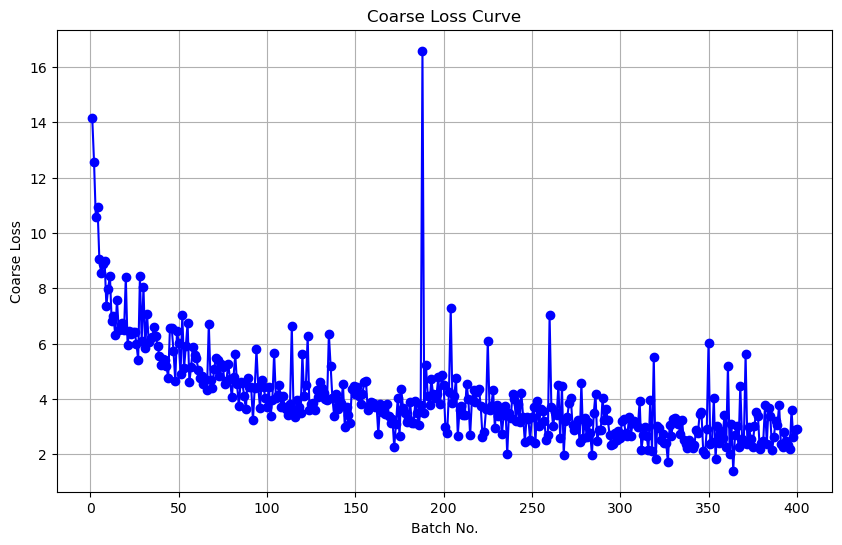

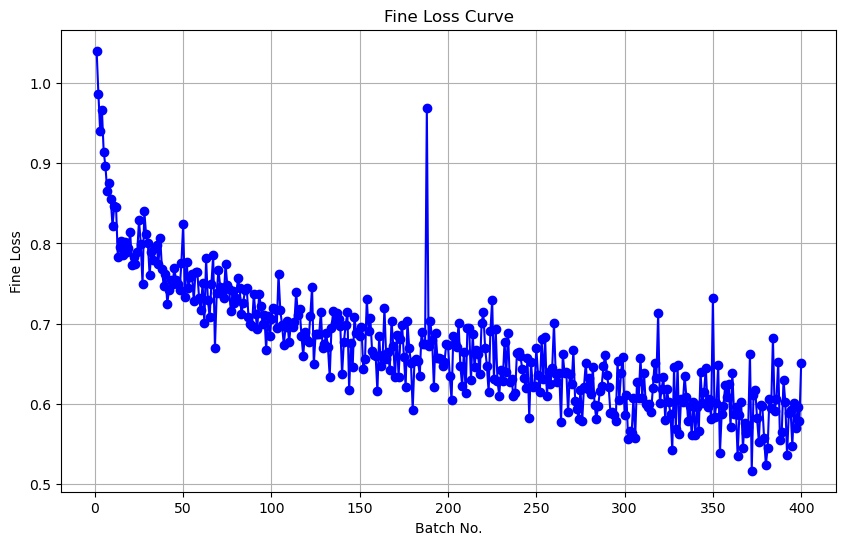

In [9]:
plot_loss_curve(coarse_loss_history, title="Coarse Loss Curve", ylabel="Coarse Loss")
plot_loss_curve(fine_loss_history, title="Fine Loss Curve", ylabel="Fine Loss")

In [10]:
from source.miscellaneous.model_saving import save_model

In [11]:
hyperparameters = {
    "lr":learning_rate,
    "wd": weight_decay,
    "coarse_context": use_coarse_context,
    "img_size": "3344_3904",
    "ResNet": "16_4",
    "transform_threshold":transformation_threshold,
    "temp": temperature,
    "bs": batch_size,
    "coarse_loss": coarse_loss
}

if coarse_loss == "focal":
    hyperparameters["gamma"]=gamma
    hyperparameters["alpha"]=alpha

models = {"backbone": backbone, "coarse_loftr": coarse_loftr, "fine_loftr": fine_loftr}
save_model(models, hyperparameters=hyperparameters, coarse_loss_history=coarse_loss_history, fine_loss_history=fine_loss_history)

'../../models/lr0p0004_wd0p0015_coarse_contextTrue_img_size3344_3904_ResNet16_4_transform_threshold0p3_temp0p15_bs2_coarse_lossfocal_gamma1p5_alpha0p75_v1'